In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from IPython.display import Audio

import librosa
import librosa.display
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
file_path = "/content/drive/My Drive/ML - 2/Assignment - 3/spectrograms.h5"

with h5py.File(file_path, 'r') as f:
    keys = list(f.keys())
    print("Keys in file:")
    for key in keys:
        print(key)
        dataset = f[key]
        print("Shape:", dataset.shape)

Keys in file:
amecro
Shape: (256, 343, 52)
barswa
Shape: (256, 343, 55)
bkcchi
Shape: (256, 343, 57)
blujay
Shape: (256, 343, 50)
daejun
Shape: (256, 343, 58)
houfin
Shape: (256, 343, 44)
mallar3
Shape: (256, 343, 36)
norfli
Shape: (256, 343, 59)
rewbla
Shape: (256, 343, 41)
stejay
Shape: (256, 343, 40)
wesmea
Shape: (256, 343, 36)
whcspa
Shape: (256, 343, 51)


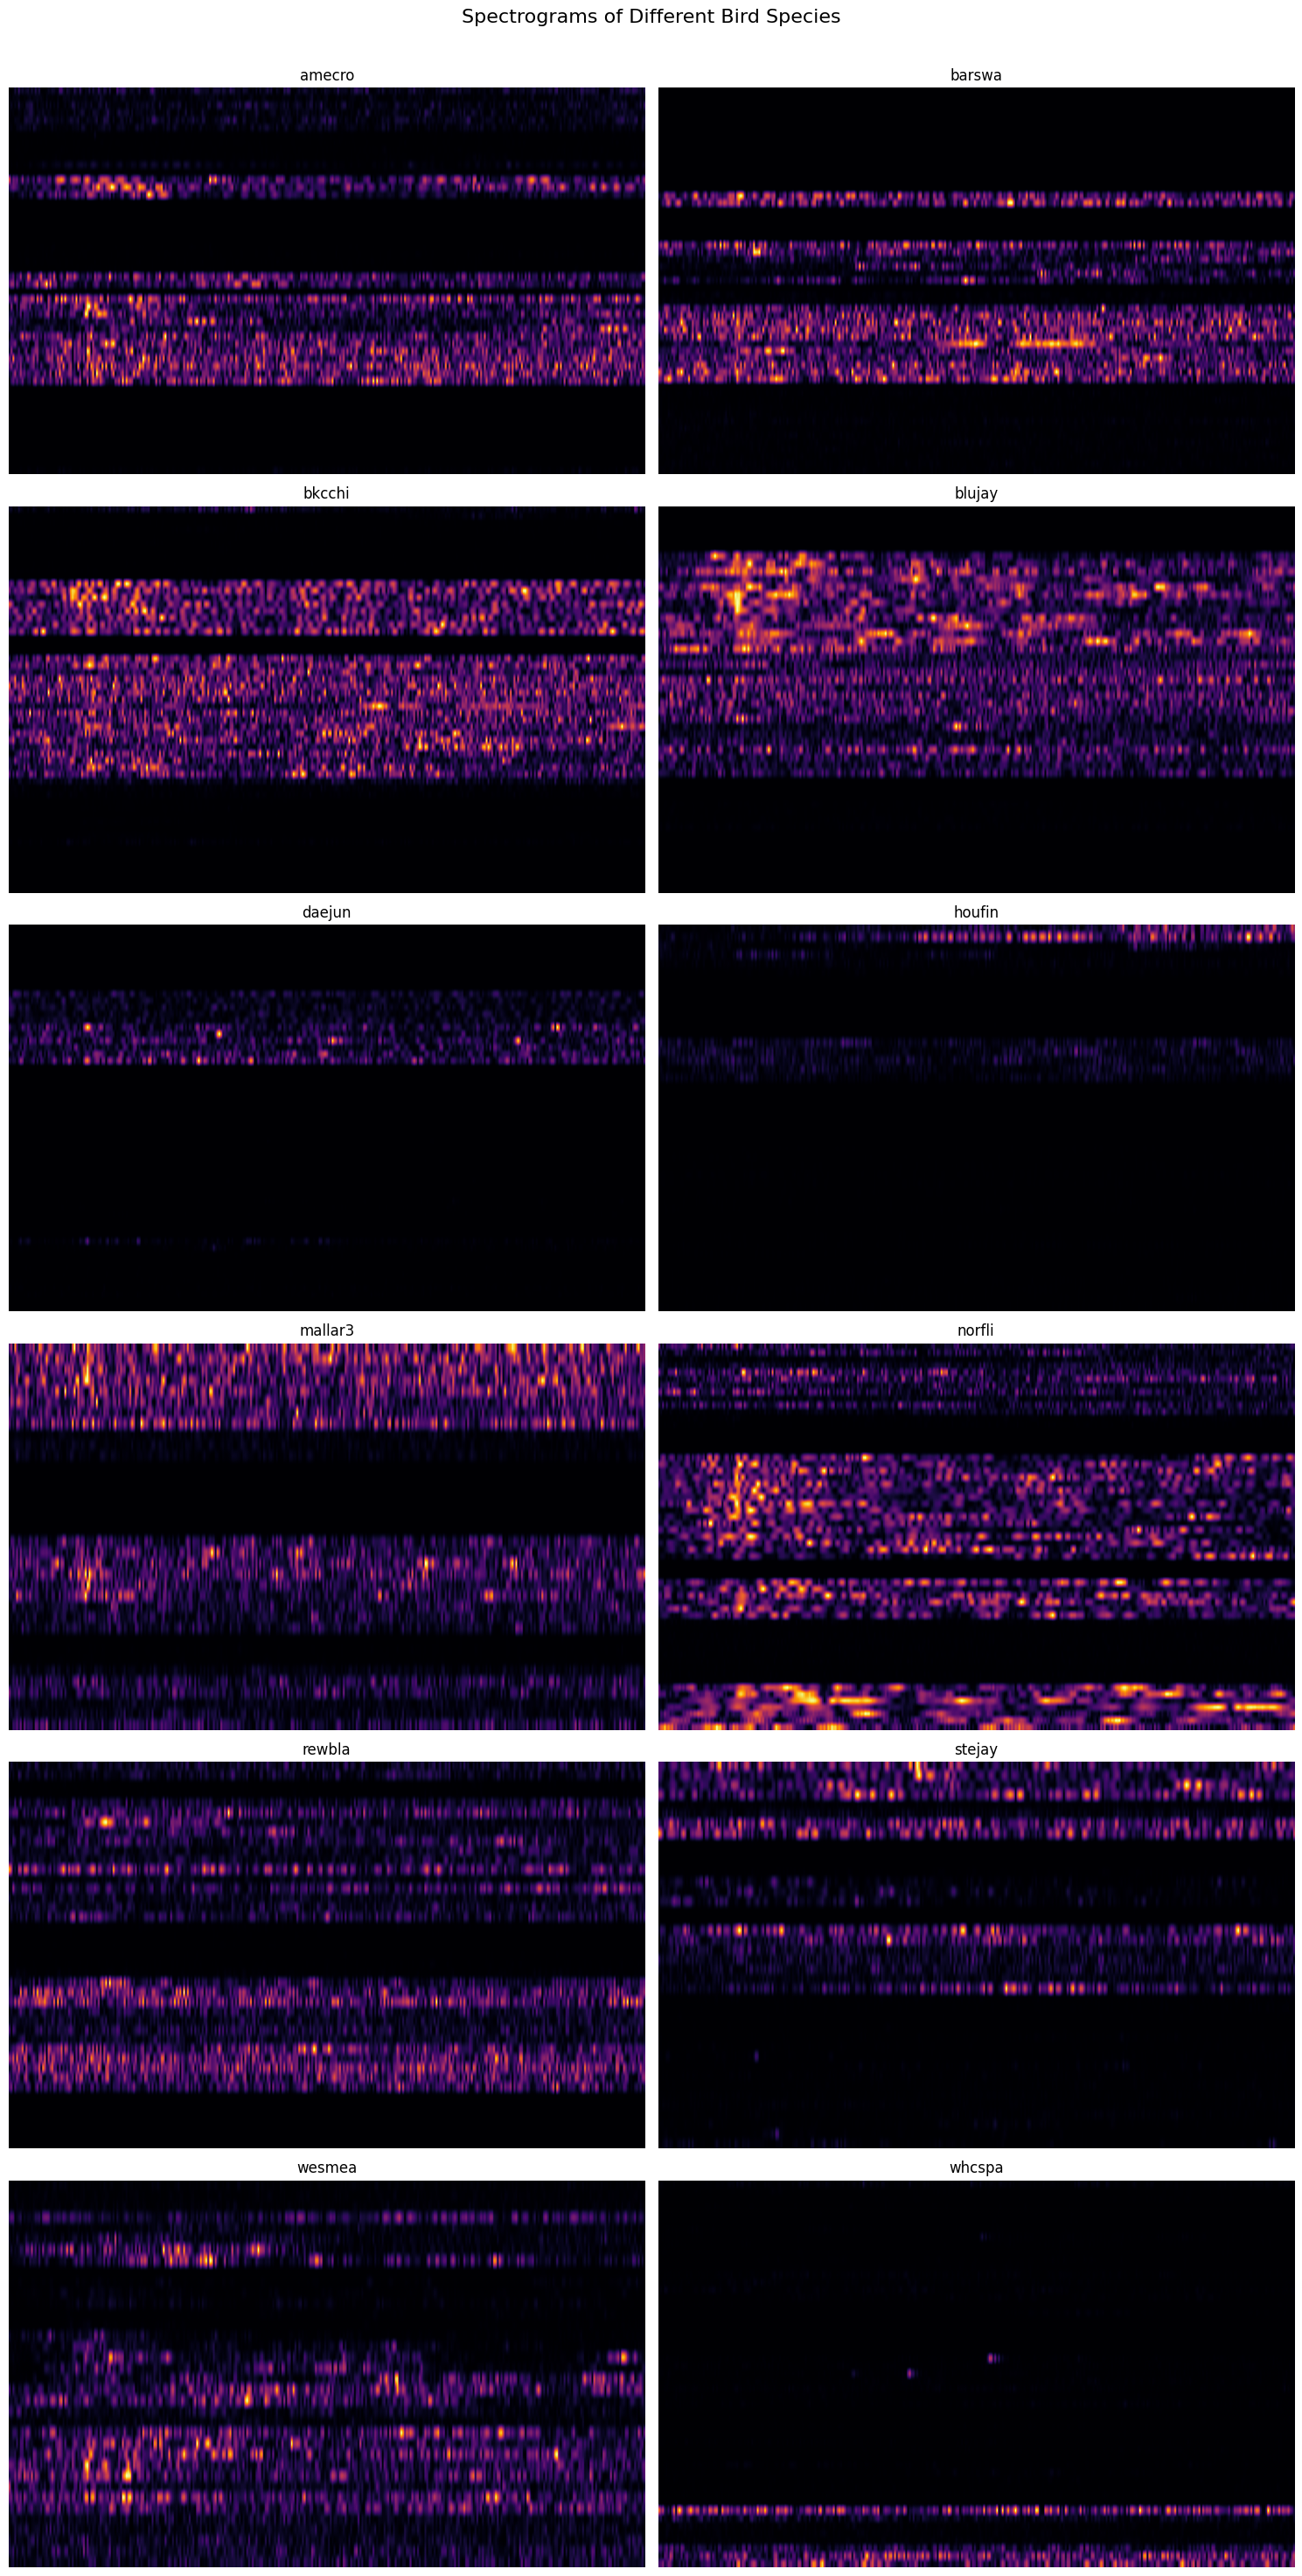

In [20]:
import h5py
import matplotlib.pyplot as plt

with h5py.File(file_path, 'r') as f:
    species_keys = list(f.keys())
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
    fig.suptitle('Spectrograms of Different Bird Species', fontsize=16)

    for ax, key in zip(axes.flat, species_keys):
        dset = f[key]
        spectrogram = dset[0]
        ax.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='inferno')
        ax.set_title(key)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


#Binary Classification

##Model 1 - Without Dropout Layer

In [21]:
file_path = "/content/drive/My Drive/ML - 2/Assignment - 3/spectrograms.h5"

with h5py.File(file_path, 'r') as f:
    species_list_new = list(f.keys())
    print(f"New Species list: {species_list_new}")

    amecro_data_new = f['amecro'][:]
    blujay_data_new = f['blujay'][:]

amecro_labels_new = np.zeros(amecro_data_new.shape[2])
blujay_labels_new = np.ones(blujay_data_new.shape[2])
X_new = np.concatenate((amecro_data_new.transpose(2, 1, 0), blujay_data_new.transpose(2, 1, 0)), axis=0)
y_new = np.concatenate((amecro_labels_new, blujay_labels_new), axis=0)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
nsamples_new, nx_new, ny_new = X_train_new.shape
X_train_reshaped_new = X_train_new.reshape((nsamples_new, nx_new*ny_new))

scaler_new = StandardScaler().fit(X_train_reshaped_new)
X_train_scaled_new = scaler_new.transform(X_train_reshaped_new)

nsamples_test_new, nx_test_new, ny_test_new = X_test_new.shape
X_test_reshaped_new = X_test_new.reshape((nsamples_test_new, nx_test_new*ny_test_new))
X_test_scaled_new = scaler_new.transform(X_test_reshaped_new)

X_train_scaled_cnn_new = X_train_scaled_new.reshape((nsamples_new, nx_new, ny_new, 1))
X_test_scaled_cnn_new = X_test_scaled_new.reshape((nsamples_test_new, nx_test_new, ny_test_new, 1))

log_reg_new = LogisticRegression(random_state=123)
log_reg_new.fit(X_train_scaled_new, y_train_new)
y_pred_log_reg_new = log_reg_new.predict(X_test_scaled_new)
log_reg_accuracy_new = accuracy_score(y_test_new, y_pred_log_reg_new)
log_reg_accuracy_new = log_reg_accuracy_new * 100
print(f"Linear Regression test accuracy: {log_reg_accuracy_new:.4f}")

np.random.seed(123)
tf.random.set_seed(123)

# CNN Model without Dropout
bina_new_no_dropout = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(343, 256, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bina_new_no_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_no_dropout = bina_new_no_dropout.fit(X_train_scaled_cnn_new, y_train_new, validation_data=(X_test_scaled_cnn_new, y_test_new), epochs=10)


New Species list: ['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Regression test accuracy: 85.7143
Epoch 1/10
3/3 [==============================] - 30s 7s/step - loss: 14.0178 - accuracy: 0.4938 - val_loss: 15.5138 - val_accuracy: 0.3810
Epoch 2/10
3/3 [==============================] - 16s 6s/step - loss: 4.5178 - accuracy: 0.6667 - val_loss: 1.1419 - val_accuracy: 0.8095
Epoch 3/10
3/3 [==============================] - 16s 6s/step - loss: 1.9307 - accuracy: 0.7407 - val_loss: 0.6520 - val_accuracy: 0.8095
Epoch 4/10
3/3 [==============================] - 16s 6s/step - loss: 0.6515 - accuracy: 0.8272 - val_loss: 0.1908 - val_accuracy: 0.9048
Epoch 5/10
3/3 [==============================] - 17s 6s/step - loss: 0.2664 - accuracy: 0.8519 - val_loss: 0.1243 - val_accuracy: 0.9524
Epoch 6/10
3/3 [==============================] - 16s 6s/step - loss: 0.1512 - accuracy: 0.9630 - val_loss: 0.1249 - val_accuracy: 0.9524
Epoch 7/10
3/3 [==============================] - 16s 6s/step - loss: 0.1215 - accuracy: 0.9753 - val_loss: 0.1239 - val_accuracy

In [22]:
test_loss_no_dropout, test_accuracy_no_dropout = bina_new_no_dropout.evaluate(X_test_scaled_cnn_new, y_test_new)
test_accuracy_no_dropout = test_accuracy_no_dropout * 100
print(f"CNN (without dropout) test accuracy: {test_accuracy_no_dropout:.4f}")
print(f"CNN (without dropout) test loss: {test_loss_no_dropout:.4f}")

train_loss_no_dropout = history_no_dropout.history['loss'][-1]
train_accuracy_no_dropout = history_no_dropout.history['accuracy'][-1] * 100
print(f"CNN (without dropout) train accuracy: {train_accuracy_no_dropout:.4f}")
print(f"CNN (without dropout) train loss: {train_loss_no_dropout:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.6283 - accuracy: 0.9048
CNN (without dropout) test accuracy: 90.4762
CNN (without dropout) test loss: 0.6283
CNN (without dropout) train accuracy: 98.7654
CNN (without dropout) train loss: 0.0764


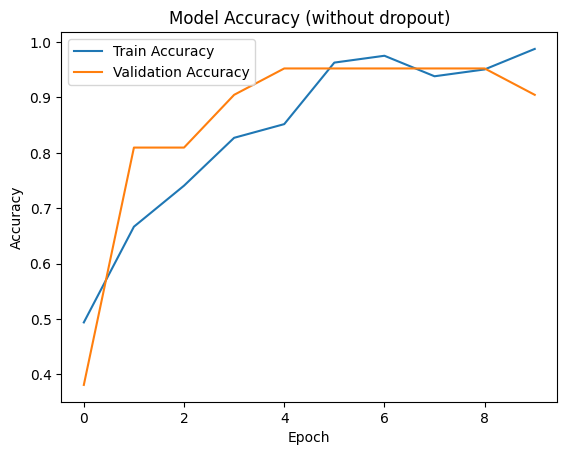

In [23]:
plt.plot(history_no_dropout.history['accuracy'], label='Train Accuracy')
plt.plot(history_no_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (without dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

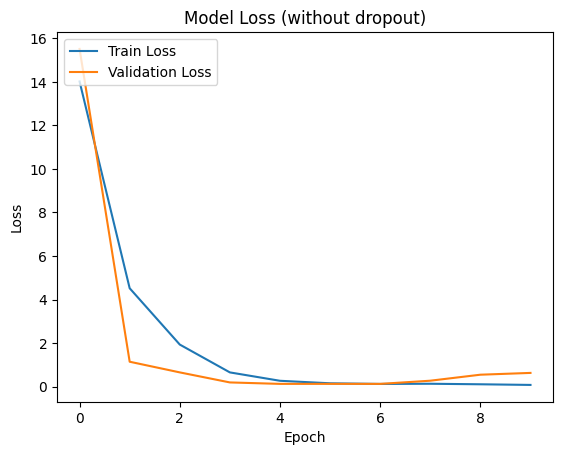

In [24]:
plt.plot(history_no_dropout.history['loss'], label='Train Loss')
plt.plot(history_no_dropout.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (without dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')



##Model 2 - With Dropout Layer

In [25]:
np.random.seed(123)
tf.random.set_seed(123)

# CNN Model with Dropout
bina_new = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(nx_new, ny_new, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bina_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_new = bina_new.fit(X_train_scaled_cnn_new, y_train_new, validation_data=(X_test_scaled_cnn_new, y_test_new), epochs=10)

Epoch 1/10
3/3 [==============================] - 18s 6s/step - loss: 7.1024 - accuracy: 0.5432 - val_loss: 40.0218 - val_accuracy: 0.3810
Epoch 2/10
3/3 [==============================] - 18s 6s/step - loss: 9.6881 - accuracy: 0.7037 - val_loss: 3.5009 - val_accuracy: 0.7143
Epoch 3/10
3/3 [==============================] - 16s 6s/step - loss: 2.9804 - accuracy: 0.7037 - val_loss: 0.7132 - val_accuracy: 0.8095
Epoch 4/10
3/3 [==============================] - 16s 6s/step - loss: 0.5412 - accuracy: 0.8642 - val_loss: 0.9805 - val_accuracy: 0.8095
Epoch 5/10
3/3 [==============================] - 15s 5s/step - loss: 0.3033 - accuracy: 0.8272 - val_loss: 0.0928 - val_accuracy: 0.9524
Epoch 6/10
3/3 [==============================] - 15s 5s/step - loss: 0.1356 - accuracy: 0.9259 - val_loss: 0.2168 - val_accuracy: 0.9524
Epoch 7/10
3/3 [==============================] - 15s 5s/step - loss: 0.2272 - accuracy: 0.9753 - val_loss: 0.0529 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=================

In [26]:
test_loss_new, test_accuracy_new = bina_new.evaluate(X_test_scaled_cnn_new, y_test_new)
test_accuracy_new = test_accuracy_new * 100
test_loss_new = test_loss_new * 100
print(f"Test accuracy: {test_accuracy_new:.4f}")
print(f"Test loss: {test_loss_new:.4f}")

train_loss_new = history_new.history['loss'][-1]
train_accuracy_new = history_new.history['accuracy'][-1] * 100
train_loss_new = train_loss_new * 100
print(f"Train accuracy: {train_accuracy_new:.4f}")
print(f"Train loss: {train_loss_new:.4f}")

1/1 [==============================] - 1s 725ms/step - loss: 0.0521 - accuracy: 1.0000
Test accuracy: 100.0000
Test loss: 5.2127
Train accuracy: 98.7654
Train loss: 8.9658


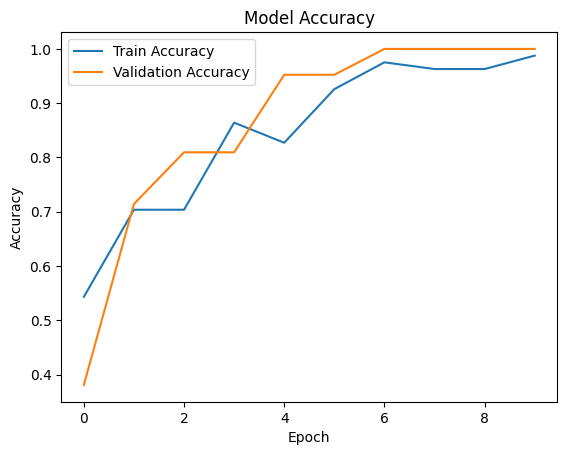

In [27]:

plt.plot(history_new.history['accuracy'], label='Train Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

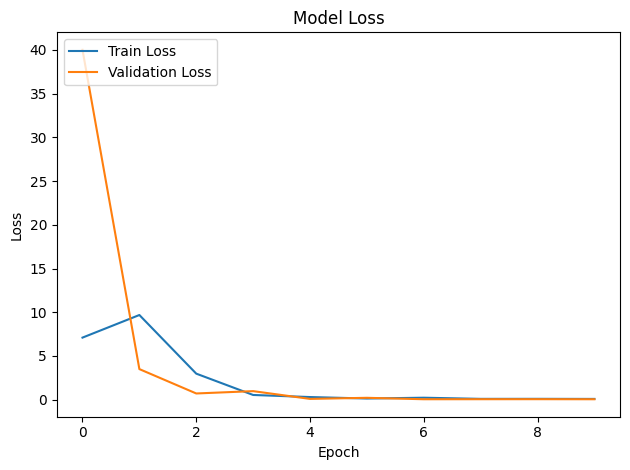

In [28]:

plt.plot(history_new.history['loss'], label='Train Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#Multi-Class

##Model 1 - without Dropout Layer

In [29]:
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
file_path = "/content/drive/My Drive/ML - 2/Assignment - 3/spectrograms.h5"

with h5py.File(file_path, 'r') as f:
    species_names_multiclass = ['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']
    data = []
    labels = []
    for species in species_names_multiclass:
        species_data = f[species][:]
        species_label = [species_names_multiclass.index(species)] * species_data.shape[2]
        data.append(species_data.transpose(2, 1, 0))
        labels.extend(species_label)
X = np.concatenate(data, axis=0)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
X_train_scaled = X_train_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

# Model 1 without Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(species_names_multiclass), activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=10)

Epoch 1/10
15/15 [==============================] - 102s 6s/step - loss: 9.5364 - accuracy: 0.2743 - val_loss: 1.9456 - val_accuracy: 0.4397
Epoch 2/10
15/15 [==============================] - 87s 6s/step - loss: 1.2128 - accuracy: 0.7063 - val_loss: 1.0993 - val_accuracy: 0.6466
Epoch 3/10
15/15 [==============================] - 95s 6s/step - loss: 0.3431 - accuracy: 0.9093 - val_loss: 1.0384 - val_accuracy: 0.6897
Epoch 4/10
15/15 [==============================] - 90s 6s/step - loss: 0.1365 - accuracy: 0.9719 - val_loss: 1.3963 - val_accuracy: 0.6638
Epoch 5/10
15/15 [==============================] - 85s 6s/step - loss: 0.0764 - accuracy: 0.9806 - val_loss: 1.6090 - val_accuracy: 0.6897
Epoch 6/10
15/15 [==============================] - 92s 6s/step - loss: 0.1177 - accuracy: 0.9892 - val_loss: 1.7694 - val_accuracy: 0.7069
Epoch 7/10
15/15 [==============================] - 86s 6s/step - loss: 0.0941 - accuracy: 0.9892 - val_loss: 1.2152 - val_accuracy: 0.7069
Epoch 8/10
15/15 [=

In [30]:
test_loss1, test_accuracy1 = model1.evaluate(X_test_scaled, y_test)
test_accuracy1 = test_accuracy1 * 100
print(f"Model 1 Test accuracy: {test_accuracy1:.4f}")
print(f"Model 1 Test loss: {test_loss1:.4f}")

train_loss1 = history1.history['loss'][-1]
train_accuracy1 = history1.history['accuracy'][-1] * 100
print(f"Model 1 Train accuracy: {train_accuracy1:.4f}")
print(f"Model 1 Train loss: {train_loss1:.4f}")

4/4 [==============================] - 4s 955ms/step - loss: 1.4356 - accuracy: 0.7155
Model 1 Test accuracy: 71.5517
Model 1 Test loss: 1.4356
Model 1 Train accuracy: 100.0000
Model 1 Train loss: 0.0088


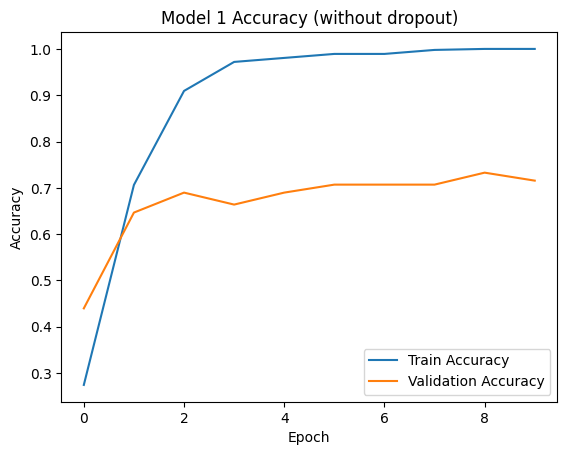

In [37]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy (without dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

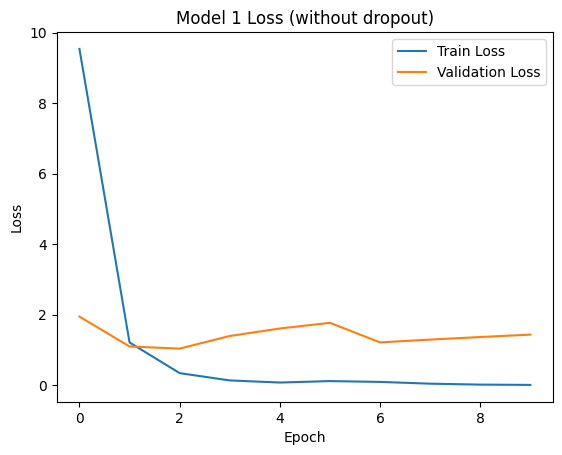

In [38]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss (without dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

##Model2 - Adding Dropout Layer

In [33]:
# Model 2 with Dropout
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(species_names_multiclass), activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=10)

Epoch 1/10
15/15 [==============================] - 90s 6s/step - loss: 7.9407 - accuracy: 0.2635 - val_loss: 1.9487 - val_accuracy: 0.5000
Epoch 2/10
15/15 [==============================] - 91s 6s/step - loss: 1.6691 - accuracy: 0.5896 - val_loss: 1.4230 - val_accuracy: 0.5948
Epoch 3/10
15/15 [==============================] - 85s 6s/step - loss: 0.9516 - accuracy: 0.7495 - val_loss: 1.0566 - val_accuracy: 0.6810
Epoch 4/10
15/15 [==============================] - 87s 6s/step - loss: 0.5447 - accuracy: 0.8445 - val_loss: 1.0745 - val_accuracy: 0.7069
Epoch 5/10
15/15 [==============================] - 89s 6s/step - loss: 0.3623 - accuracy: 0.9006 - val_loss: 1.0479 - val_accuracy: 0.6810
Epoch 6/10
15/15 [==============================] - 90s 6s/step - loss: 0.2105 - accuracy: 0.9546 - val_loss: 1.1315 - val_accuracy: 0.7069
Epoch 7/10
15/15 [==============================] - 88s 6s/step - loss: 0.1302 - accuracy: 0.9654 - val_loss: 1.1600 - val_accuracy: 0.7155
Epoch 8/10
15/15 [==

In [34]:
test_loss2, test_accuracy2 = model2.evaluate(X_test_scaled, y_test)
test_accuracy2 = test_accuracy2 * 100
print(f"Model 2 Test accuracy: {test_accuracy2:.4f}")
print(f"Model 2 Test loss: {test_loss2:.4f}")

train_loss2 = history2.history['loss'][-1]
train_accuracy2 = history2.history['accuracy'][-1] * 100
print(f"Model 2 Train accuracy: {train_accuracy2:.4f}")
print(f"Model 2 Train loss: {train_loss2:.4f}")

4/4 [==============================] - 6s 1s/step - loss: 1.2847 - accuracy: 0.6724
Model 2 Test accuracy: 67.2414
Model 2 Test loss: 1.2847
Model 2 Train accuracy: 98.0562
Model 2 Train loss: 0.0864


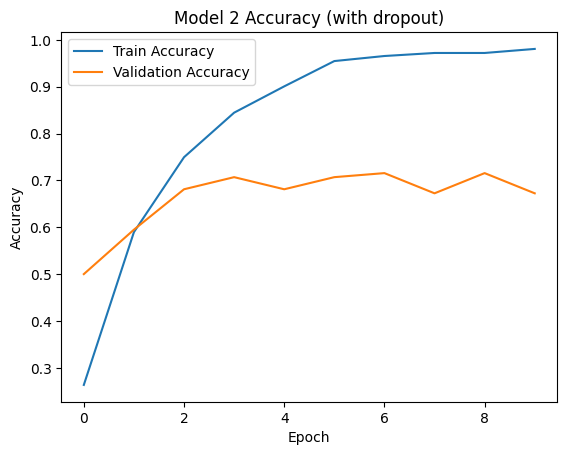

In [35]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy (with dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

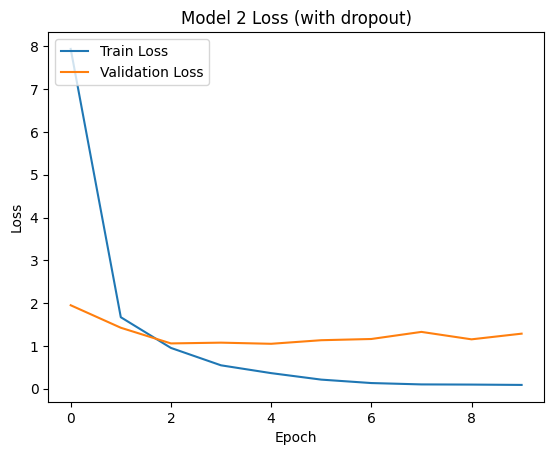

In [36]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss (with dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

#Test

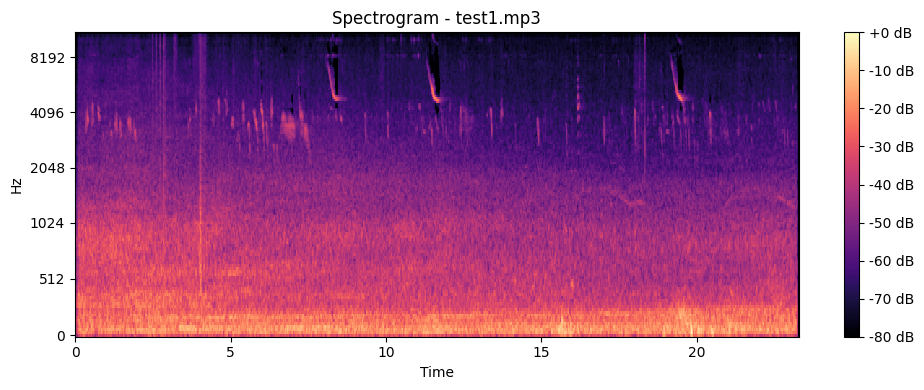

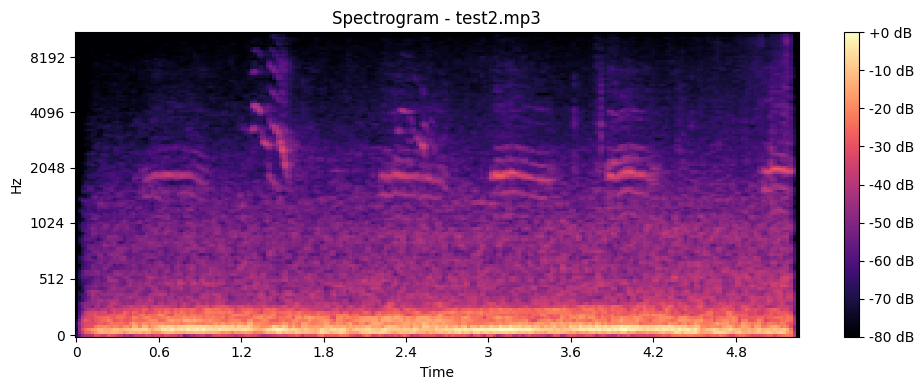

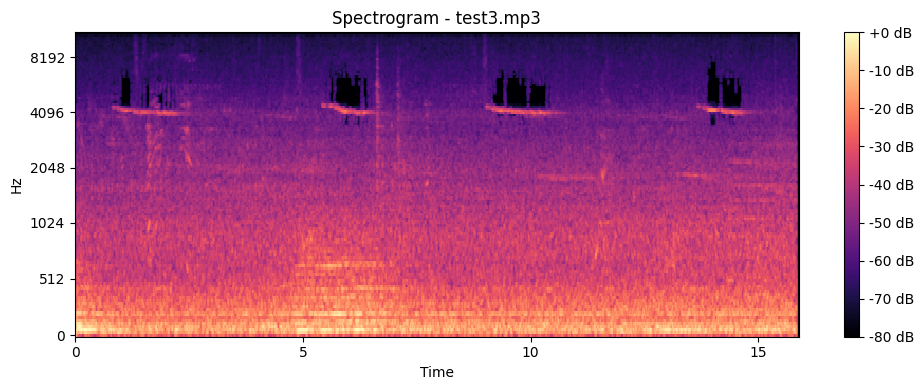

In [40]:
import librosa
import librosa.display

def generate_spectrograms(audio_paths):
    spectrograms = []
    for audio_path in audio_paths:

        y, sr = librosa.load(audio_path)

        S = librosa.feature.melspectrogram(y=y, sr=sr)

        S_db = librosa.power_to_db(S, ref=np.max)

        spectrograms.append(S_db)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram - ' + audio_path.split('/')[-1])
        plt.tight_layout()
        plt.show()

    return spectrograms

audio_paths = ["/content/drive/My Drive/ML - 2/Assignment - 3/test_birds/test1.mp3",
               "/content/drive/My Drive/ML - 2/Assignment - 3/test_birds/test2.mp3",
               "/content/drive/My Drive/ML - 2/Assignment - 3/test_birds/test3.mp3"]

spectrograms = generate_spectrograms(audio_paths)


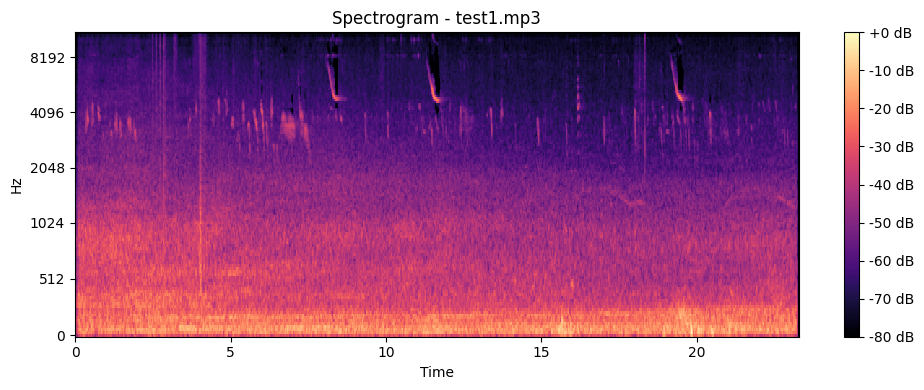

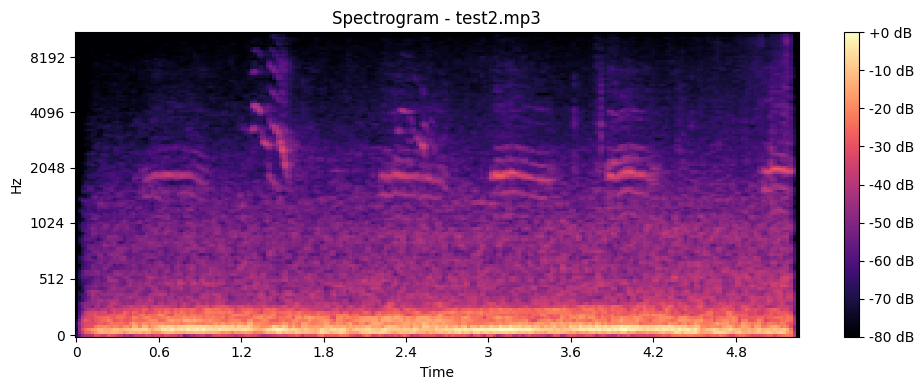

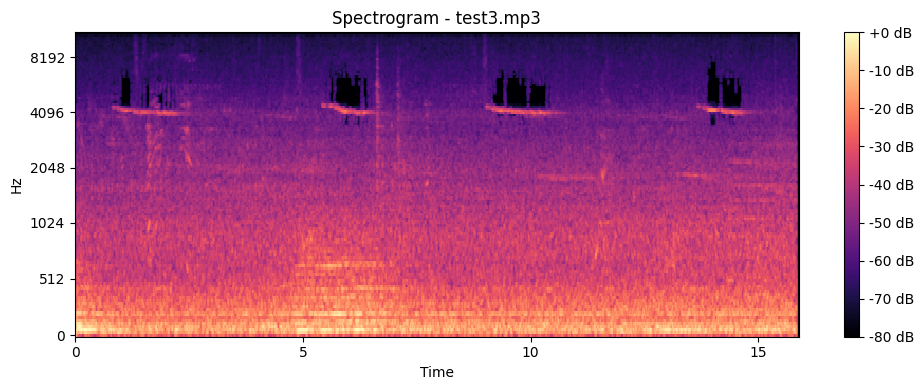

1/1 [==============================] - 0s 354ms/step
Prediction for spectrogram 1: norfli
Prediction for spectrogram 2: wesmea
Prediction for spectrogram 3: wesmea


In [41]:
import numpy as np
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

spectrograms = generate_spectrograms(audio_paths)

desired_shape = (343, 256)

processed_spectrograms = [resize(spectrogram, desired_shape, anti_aliasing=True) for spectrogram in spectrograms]

spectrograms = np.array(processed_spectrograms)

spectrograms_flat = spectrograms.reshape(spectrograms.shape[0], -1)

scaler = StandardScaler()
scaler.fit(X_train_scaled.reshape(X_train_scaled.shape[0], -1))
spectrograms_scaled_flat = scaler.transform(spectrograms_flat)

spectrograms_scaled = spectrograms_scaled_flat.reshape(spectrograms.shape)
spectrograms_scaled = spectrograms_scaled[..., np.newaxis]

predictions = model2.predict(spectrograms_scaled)

predicted_indices = np.argmax(predictions, axis=1)
predicted_species = [species_names_multiclass[idx] for idx in predicted_indices]

for i, species in enumerate(predicted_species):
    print(f"Prediction for spectrogram {i + 1}: {species}")
